In [6]:
cd IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/

[Errno 2] No such file or directory: 'IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project/'
/home/ckb2084/research/IMGS-789-Advanced-Robust-ML-for-Interdisciplinary-Imaging-Science-Applications/group_project


/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [7]:
# Neccesary imports
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from time import time
import random
import glob, os

from sklearn.model_selection import train_test_split

# from scipy.ndimage.filters import gaussian_filter1d
# import torchvision.models as models
# from tqdm import tqdm
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt
# from accelerate import Accelerator
# cm = plt.get_cmap('RdYlBu')
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch.nn import LayerNorm
# import math
# from sklearn.model_selection import train_test_split
# import seaborn as sns
# import matplotlib.colors as mcolors
# import pandas as pd

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from scipy.stats import gaussian_kde

In [8]:
%%time
# Import all the data
data = pd.read_pickle('grism_specPT.pkl')
data_sed = pd.read_pickle('sed_fitting.pkl')


data_sed_chi_l5 = data_sed[data_sed['best.reduced_chi_square'] <= 10.0]
data_sed_chi_l5.reset_index(drop=True, inplace=True)
id = [int(i) for i in data_sed_chi_l5['id']]

# pulling only datapoints with a SNR at or above 2.5 and a redshift below 1.7
data = data[data['SNR']>=2.5]
data_subset = data[data['z']<1.7]
# data_subset = data_subset.iloc[id]
# data_subset.reset_index(drop=True, inplace=True)

data_subset.head()

CPU times: user 1.29 s, sys: 1.53 s, total: 2.83 s
Wall time: 2.83 s


,grism_id,wavelength,flux,z,SNR,continuum_sub_flux
2,aegis-26-G141_00469,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.43,4.094828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,aegis-26-G141_00703,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.40,20.695364,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,aegis-26-G141_00836,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.56,6.308725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,aegis-26-G141_00910,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.05,4.627907,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,aegis-26-G141_00937,"[10208.409432389317, 10209.33721533346, 10210....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.51,8.418367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# Split the data into 70% train and 30% temp_test
train_df, temp_test_df = train_test_split(data_subset, test_size=0.3, random_state=42)

# Split the temp_test into 50% test and 50% validation, which is 15% each of the original
test_df, val_df = train_test_split(temp_test_df, test_size=0.5, random_state=42)

# Print the sizes of each set
print(f'Train set size: {len(train_df)}')
print(f'Validation set size: {len(test_df)}')
print(f'Test set size: {len(val_df)}')

Train set size: 6078
Validation set size: 1302
Test set size: 1303


## Loading in SpecPT

In [10]:
from SpecPT import (
    SpecPT, 
    SpecPTForRedshift, 
    CustomLoadDataset_Autoencoder,
    Swish,
    # CustomLoadDataset_Redshift, 
    NMADLoss, 
    evaluate
)

In [11]:
class EnhancedSpecPTForRedshift(nn.Module):
    def __init__(self, pretrained_model, output_features=1, num_mlp_blocks=5, mlp_dim=512, dropout_rate=0.2):
        super(EnhancedSpecPTForRedshift, self).__init__()
        
        self.encoder = pretrained_model.transformer_encoder
        self.proj_to_d_model = pretrained_model.proj_to_d_model
        self.forward_conv = pretrained_model.forward_conv
        
        # Fine-tune the last few layers of the encoder
        for param in list(self.encoder.parameters())[-4:]:
            param.requires_grad = True
        
        self.mlp_blocks = nn.Sequential(
            *[ImprovedResidualMLPBlock(mlp_dim if i > 0 else 512, mlp_dim, dropout_rate) for i in range(num_mlp_blocks)]
        )
        
        self.prediction = nn.Sequential(
            nn.Linear(mlp_dim, mlp_dim // 2),
            Swish(),
            nn.Dropout(dropout_rate),
            nn.Linear(mlp_dim // 2, output_features),
            nn.Softplus()
        )
        
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.forward_conv(x)
        x = x.flatten(start_dim=1)
        x = self.proj_to_d_model(x)
        x = x.unsqueeze(0)
        
        encoded_features = self.encoder(x)
        encoded_features = encoded_features.squeeze(0)
        
        # Apply attention mechanism
        attn_output, _ = self.attention(encoded_features, encoded_features, encoded_features)
        x = attn_output + encoded_features  # Residual connection
        
        x = self.mlp_blocks(x)
        redshift = self.prediction(x)
        return redshift

class ImprovedResidualMLPBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate):
        super(ImprovedResidualMLPBlock, self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        self.swish = Swish()
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        residual = x
        x = self.swish(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = x + residual  # Residual connection
        x = self.layer_norm(x)
        return self.swish(x)


In [12]:
# Dataset Loader for Redshift
class CustomLoadDataset_Redshift(Dataset):
    def __init__(self, df):
        x = []
        y = []
        target_id = []
            
        for index, row in df.iterrows():
            fl = row['flux']
            if np.median(fl) > 0:
                fl = fl / np.median(fl)
                x.append(fl)
                y.append(np.array([row['z']]))
                target_id.append(row['grism_id'])

        self.X = torch.from_numpy(np.stack(x, axis=0))
        self.Y = torch.from_numpy(np.stack(y, axis=0))
        self.t_id = target_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.Y[idx].float(), idx, self.t_id[idx]


In [13]:
config = {
    "input_size": 7781,
    "d_model": 512,
    "nhead": 8,
    "num_encoder_layers": 3,
    "num_decoder_layers": 3,
    "dim_feedforward": 2048,
    "learning_rate": 5e-5,
    "batch_size": 64,  # Reduced batch size
    "num_mlp_blocks": 5,  # increased from 2
    "mlp_dim": 512,
    "dropout_rate": 0.8, ## Changed from 0.8
    "weight_decay": 1e-3  # Added weight decay
}


In [14]:
from accelerate import Accelerator
accelerator = Accelerator()
additional_features_dim = data_sed_chi_l5['flux'][0].shape[0]
model = SpecPT(input_size=7781) #, d_head=16
# model.load_state_dict(torch.load('redshift_prediction_model_1D_large_kernel_staggered_training.pth'))

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_training_HST_150.pth', map_location='cpu')  # Load to CPU first 
file_path = os.path.expanduser('~/research/galax_spec/pretrained_weights')
# state_dict = torch.load(f'{file_path}/SpecPT_DESI_combined_autoencoder_150.pth', map_location='cpu')
state_dict = torch.load(f'{file_path}/SpecPT_training_HST_150.pth', map_location='cpu')

model.load_state_dict(state_dict)
model.to(accelerator.device)
# Initialize the modified SpecPT model for redshift prediction
# redshift_model = SpecPTForRedshift(model)  # `model` is the pretrained SpecPT instance
redshift_model = EnhancedSpecPTForRedshift(
    model, 
    output_features=1, 
    num_mlp_blocks=config["num_mlp_blocks"], 
    mlp_dim=config["mlp_dim"], 
    dropout_rate=config["dropout_rate"],
    # additional_features_dim=additional_features_dim
)

# Load the model state
# state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_photo'+str(epochs*n)+'.pth', map_location='cpu')  # Load to CPU first
state_dict = torch.load('pretrained_weights/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_'+'500.pth', map_location='cpu')  # Load to CPU first
# state_dict = torch.load('saved_models/SpecPT_HST_redshift_model_DESI_combined_PT_Enhanced_photo_best1.pth', map_location='cpu')  # Load to CPU first


redshift_model.load_state_dict(state_dict)
redshift_model = redshift_model.to(accelerator.device)

/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_797662/4196680080.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glo

In [15]:
valid_loader = DataLoader(CustomLoadDataset_Redshift(val_df), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomLoadDataset_Redshift(test_df), batch_size=64, shuffle=False)
train_loader = DataLoader(CustomLoadDataset_Redshift(train_df), batch_size=64, shuffle=True)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM with the model and the target layer.
        Args:
            model (nn.Module): The neural network model.
            target_layer (nn.Module): The layer to compute Grad-CAM on.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None  # To store gradients of the target layer
        self.activations = None  # To store activations of the target layer

        # Register hooks to capture gradients and activations
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        """
        Hook function to save activations during the forward pass.
        Args:
            module: The layer where the hook is registered.
            input: Input to the layer.
            output: Output from the layer.
        """
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """
        Hook function to save gradients during backpropagation.
        Args:
            module: The layer where the hook is registered.
            grad_input: Gradients with respect to input.
            grad_output: Gradients with respect to output.
        """
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate the Grad-CAM heatmap for a given input tensor and target class.
        Args:
            input_tensor (torch.Tensor): Input tensor to the model.
            target_class (int): Target class index for which to compute Grad-CAM. If None, use the predicted class.

        Returns:
            heatmap (torch.Tensor): The generated Grad-CAM heatmap.
        """
        # Forward pass through the model
        output = self.model(input_tensor)

        # If no target class is specified, use the predicted class
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass to compute gradients of the target class score w.r.t. feature maps
        self.model.zero_grad()
        loss = output[0, target_class]  # Select score of the target class
        loss.backward()

        # Get feature maps and gradients from the target layer
        feature_maps = self.activations  # Activations from forward pass
        gradients = self.gradients  # Gradients from backward pass

        # Compute weights by global average pooling over spatial dimensions
        weights = torch.mean(gradients, dim=2)  # Average over width

        # Compute weighted sum of feature maps
        cam = torch.zeros_like(feature_maps[0], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            cam += w * feature_maps[0, i]

        # Apply ReLU to remove negative values
        cam = F.relu(cam)

        # Normalize CAM to [0, 1]
        cam -= cam.min()
        cam /= cam.max()

        return cam


# Example Usage with SpecPT Model

# Instantiate your SpecPT model
# model = SpecPT()

# Choose a convolutional layer for Grad-CAM (e.g., conv3)
target_layer = model.conv3

# Wrap your model with GradCAM
grad_cam = GradCAM(model=model, target_layer=target_layer)

# Sample input tensor (batch_size=1, input_size=7781)
# input_tensor = torch.randn(1, 7781)
# Sample input tensor from test data
input_tensor = torch.tensor(test_df.iloc[100]['flux']).unsqueeze(0).to(torch.float32)
input_tensor = input_tensor.to(accelerator.device)

# Generate Grad-CAM heatmap for a specific class or predicted class
heatmap = grad_cam.generate_cam(input_tensor)
print("Generated Heatmap Shape:", heatmap.shape)


/home/ckb2084/conda/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Generated Heatmap Shape: torch.Size([256, 973])


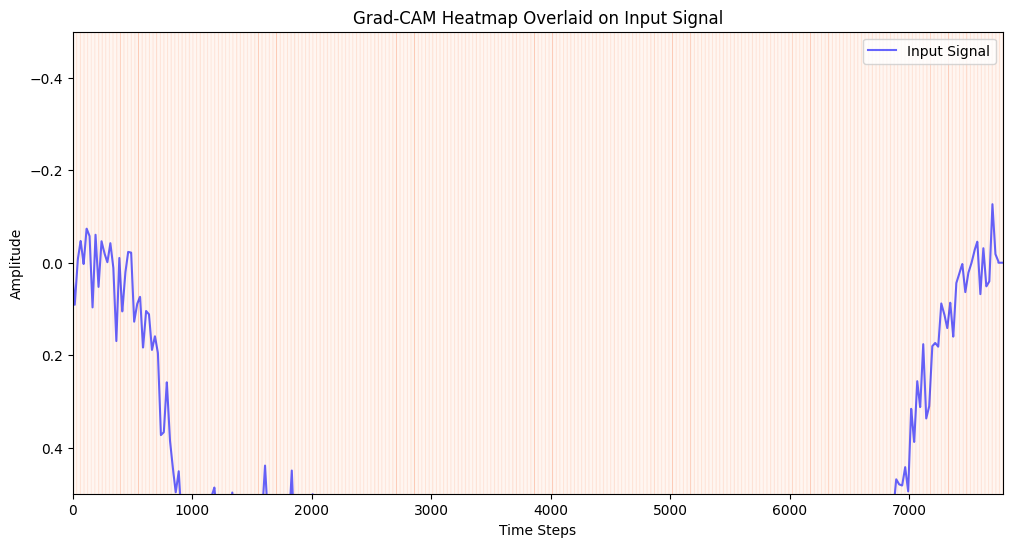

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_heatmap(input_tensor, heatmap):
    """
    Visualize Grad-CAM heatmap overlaid on the input signal.
    Args:
        input_tensor (torch.Tensor): Original input signal (1D tensor).
        heatmap (torch.Tensor): Generated Grad-CAM heatmap (1D tensor).
    """
    # Detach and convert tensors to numpy arrays
    input_signal = input_tensor.squeeze().cpu().numpy()
    heatmap = heatmap.detach().squeeze().cpu().numpy()

    # Ensure both input_signal and heatmap are 1D arrays
    if input_signal.ndim > 1:
        input_signal = input_signal.flatten()
    if heatmap.ndim > 1:
        heatmap = heatmap.flatten()

    # Rescale heatmap to match the length of the input signal if necessary
    if len(heatmap) != len(input_signal):
        heatmap = np.interp(np.arange(len(input_signal)), np.linspace(0, len(input_signal), len(heatmap)), heatmap)

    # Normalize the heatmap for better visualization
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Plot the original signal and overlay the Grad-CAM heatmap
    plt.figure(figsize=(12, 6))
    # plt.fill_between(range(len(input_signal)), input_signal * heatmap, alpha=0.5, color="red", label="Grad-CAM Heatmap")

    plt.plot(input_signal, label="Input Signal", color="blue", alpha=0.6)

    plt.imshow(
        heatmap[None, :],  # Reshape heatmap for imshow
        aspect="auto",
        cmap="Reds",
        alpha=0.9,
        # origin="lower",
    )
    plt.title("Grad-CAM Heatmap Overlaid on Input Signal")
    plt.xlabel("Time Steps")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Example usage
visualize_heatmap(input_tensor, heatmap)


In [35]:
heatmap.detach().squeeze().cpu().numpy()

array([[0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ],
       [0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ],
       [0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ],
       [0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ],
       [0.00950612, 0.0924272 , 0.6631038 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)